In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight


In [18]:
# Carga los datos
train_data = pd.read_csv('../data/galaxy_forming_burst_train.csv')
test_data = pd.read_csv('../data/galaxy_forming_burst_test.csv')

In [19]:
# Inspección inicial
print("Train Data Info:")
print(train_data.info())
print(train_data.head())

print("\nTest Data Info:")
print(test_data.info())
print(test_data.head())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59998 entries, 0 to 59997
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            59998 non-null  int64  
 1   ra            59998 non-null  float64
 2   dec           59998 non-null  float64
 3   u             59998 non-null  float64
 4   g             59998 non-null  float64
 5   r             59998 non-null  float64
 6   i             59998 non-null  float64
 7   z             59998 non-null  float64
 8   modelFlux_u   59998 non-null  float64
 9   modelFlux_g   59998 non-null  float64
 10  modelFlux_r   59998 non-null  float64
 11  modelFlux_i   59998 non-null  float64
 12  modelFlux_z   59998 non-null  float64
 13  petroRad_u    59998 non-null  float64
 14  petroRad_g    59998 non-null  float64
 15  petroRad_i    59998 non-null  float64
 16  petroRad_r    59998 non-null  float64
 17  petroRad_z    59998 non-null  float64
 18  petroFlux

In [20]:
# Resumen de valores faltantes
print("\nValores faltantes en el conjunto de entrenamiento:")
print(train_data.isnull().sum())

# Identificar valores atípicos representados por -99
print("\nConteo de valores -99 en el conjunto de entrenamiento:")
print((train_data == -99).sum())

# Reemplazar valores -99 por NaN para tratarlos adecuadamente
train_data.replace(-99, pd.NA, inplace=True)
test_data.replace(-99, pd.NA, inplace=True)


Valores faltantes en el conjunto de entrenamiento:
ID              0
ra              0
dec             0
u               0
g               0
r               0
i               0
z               0
modelFlux_u     0
modelFlux_g     0
modelFlux_r     0
modelFlux_i     0
modelFlux_z     0
petroRad_u      0
petroRad_g      0
petroRad_i      0
petroRad_r      0
petroRad_z      0
petroFlux_u     0
petroFlux_g     0
petroFlux_i     0
petroFlux_r     0
petroFlux_z     0
petroR50_u      0
petroR50_g      0
petroR50_i      0
petroR50_r      0
petroR50_z      0
psfMag_u        0
psfMag_r        0
psfMag_g        0
psfMag_i        0
psfMag_z        0
expAB_u         0
expAB_g         0
expAB_r         0
expAB_i         0
expAB_z         0
redshift        0
redshift_err    0
target          0
dtype: int64

Conteo de valores -99 en el conjunto de entrenamiento:
ID              0
ra              0
dec             0
u               0
g               0
r               0
i               0
z              

                 ID            ra           dec             u             g  \
count  5.999800e+04  59998.000000  59998.000000  59998.000000  59998.000000   
mean   1.237659e+18    180.384569     23.449607     18.126597     16.865635   
std    6.100020e+12     75.881812     21.172938    122.705999    122.690772   
min    1.237646e+18      0.009724    -11.244273  -9999.000000  -9999.000000   
25%    1.237655e+18    138.640727      2.999227     18.765855     17.510082   
50%    1.237659e+18    181.463258     20.898735     19.351790     18.074330   
75%    1.237663e+18    223.754866     42.304939     20.090335     18.662650   
max    1.237681e+18    359.993947     68.694746     30.806540     29.323290   

                  r             i             z   modelFlux_u   modelFlux_g  \
count  59998.000000  59998.000000  59998.000000  59998.000000  59998.000000   
mean      16.563169     16.037549     15.658734     30.055777     96.794240   
std      108.200242    115.664710    122.676784    

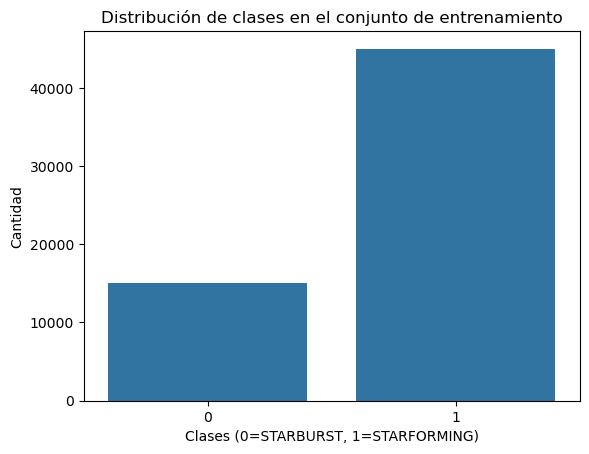

In [23]:
# Estadísticas descriptivas para características fotométricas
print(train_data.describe())

# Visualizar distribución de la variable objetivo
sns.countplot(data=train_data, x='target')
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clases (0=STARBURST, 1=STARFORMING)")
plt.ylabel("Cantidad")
plt.show()


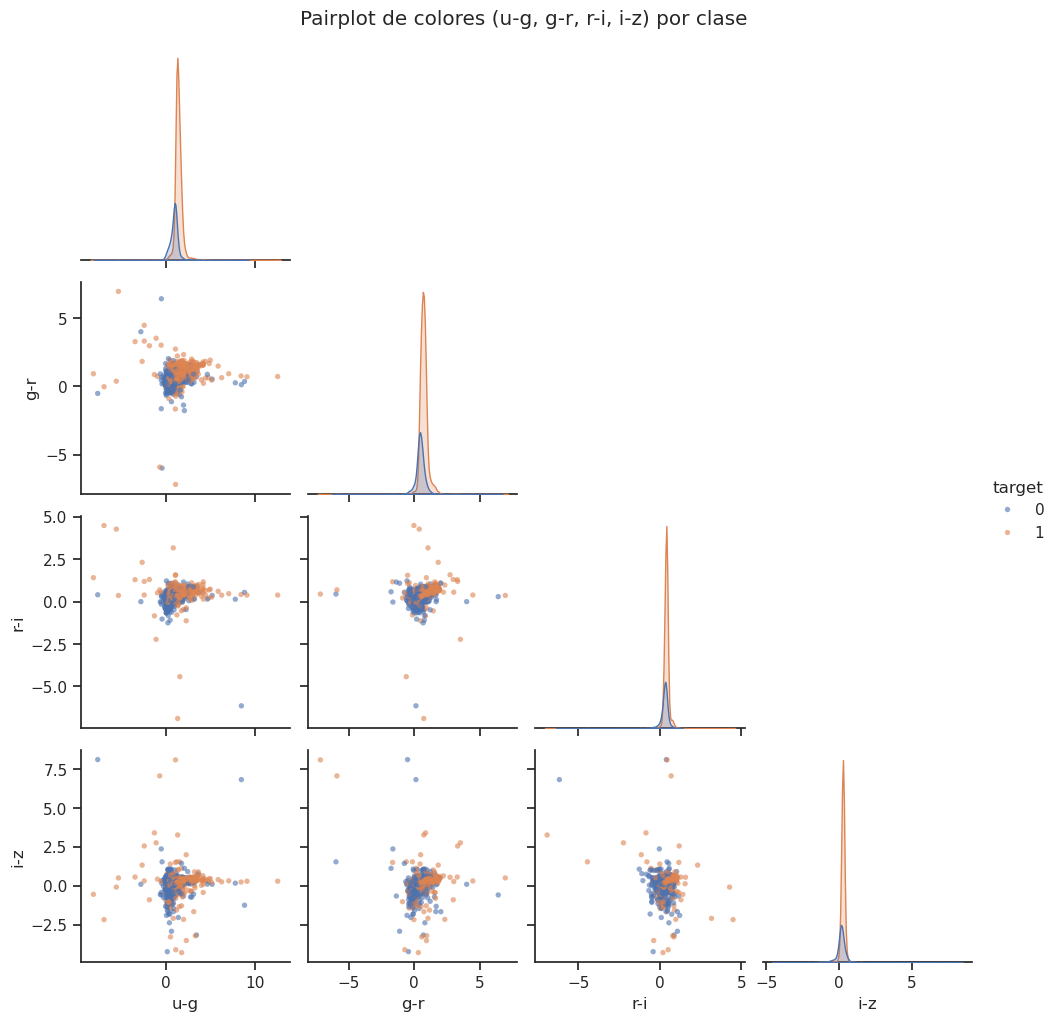

In [28]:
# Preparar variables de color y muestrear para evitar sobreplotting
cols = ['u','g','r','i','z']
# crear colores (magnitud diferencia)
train_colors = train_data[cols].copy()
train_colors['u-g'] = train_colors['u'] - train_colors['g']
train_colors['g-r'] = train_colors['g'] - train_colors['r']
train_colors['r-i'] = train_colors['r'] - train_colors['i']
train_colors['i-z'] = train_colors['i'] - train_colors['z']

color_cols = ['u-g','g-r','r-i','i-z']
# añadir target y eliminar filas con NaN en las columnas que usaremos
plot_df = pd.concat([train_colors[color_cols], train_data[['target']]], axis=1).dropna()

# reducir tamaño si hay muchos puntos
max_points = 5000
if len(plot_df) > max_points:
    plot_df = plot_df.sample(max_points, random_state=42)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', context='notebook')
sns.pairplot(plot_df, vars=color_cols, hue='target',
             plot_kws={'alpha':0.6, 's':15, 'linewidth':0},
             diag_kind='kde', corner=True, palette={0:'C0',1:'C1'})
plt.suptitle("Pairplot de colores (u-g, g-r, r-i, i-z) por clase", y=1.02)
plt.show()

In [32]:
# Imputar valores faltantes con la media para características numéricas
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

# Verificar que no queden valores faltantes
print("\nValores faltantes después de la imputación en el conjunto de entrenamiento:")
print(train_data.isnull().sum())
print("\nValores faltantes después de la imputación en el conjunto de prueba:")
print(test_data.isnull().sum())


Valores faltantes después de la imputación en el conjunto de entrenamiento:
ID              0
ra              0
dec             0
u               0
g               0
r               0
i               0
z               0
modelFlux_u     0
modelFlux_g     0
modelFlux_r     0
modelFlux_i     0
modelFlux_z     0
petroRad_u      0
petroRad_g      0
petroRad_i      0
petroRad_r      0
petroRad_z      0
petroFlux_u     0
petroFlux_g     0
petroFlux_i     0
petroFlux_r     0
petroFlux_z     0
petroR50_u      0
petroR50_g      0
petroR50_i      0
petroR50_r      0
petroR50_z      0
psfMag_u        0
psfMag_r        0
psfMag_g        0
psfMag_i        0
psfMag_z        0
expAB_u         0
expAB_g         0
expAB_r         0
expAB_i         0
expAB_z         0
redshift        0
redshift_err    0
target          0
dtype: int64

Valores faltantes después de la imputación en el conjunto de prueba:
ID              0
ra              0
dec             0
u               0
g               0
r           

In [33]:
# Crear nuevas características basadas en las magnitudes

def create_features(data):
    """
    Create new features from the photometric data.
    
    Parameters:
    data (DataFrame): The input DataFrame containing galaxy data.
    
    Returns:
    DataFrame: The DataFrame with new features added.
    """
    # Example feature engineering
    data['u_g'] = data['u'] - data['g']
    data['g_r'] = data['g'] - data['r']
    data['r_i'] = data['r'] - data['i']
    data['i_z'] = data['i'] - data['z']
 
    
    return data

In [35]:
#%% Feature selection functions

def select_features(data):
    """
    Select relevant features for model training.
    
    Parameters:
    data (DataFrame): The input DataFrame containing galaxy data.
    
    Returns:
    DataFrame: The DataFrame with selected features.
    """
    feature_columns = ['u_g', 'g_r', 'r_i', 'i_z', 'j_h']
    return data[feature_columns]

In [36]:
#%% Functions for data loading and preprocessing
def load_data(train_data):
    data = pd.read_csv(train_data)
    return data

In [37]:
#%% Preprocessing functions
def preprocess_data(data):
    # Replace -99 with NaN
    data.replace(-99, np.nan, inplace=True)
    
    # Impute missing values with the mean
    data.fillna(data.mean(), inplace=True)
    
    # Normalize features
    scaler = StandardScaler()
    feature_columns = data.columns.difference(['ID', 'target'])
    data[feature_columns] = scaler.fit_transform(data[feature_columns])
    
    return data

In [38]:
#%% Function to split data into training and validation sets
def split_data(data):
    X = data.drop(columns=['ID', 'target'])
    y = data['target']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_val, y_train, y_val

In [40]:
# Separar características de test

X_test = test_data.drop(columns=['ID'])

In [41]:
# Escaleado de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Actualizar la línea de separación de datos
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

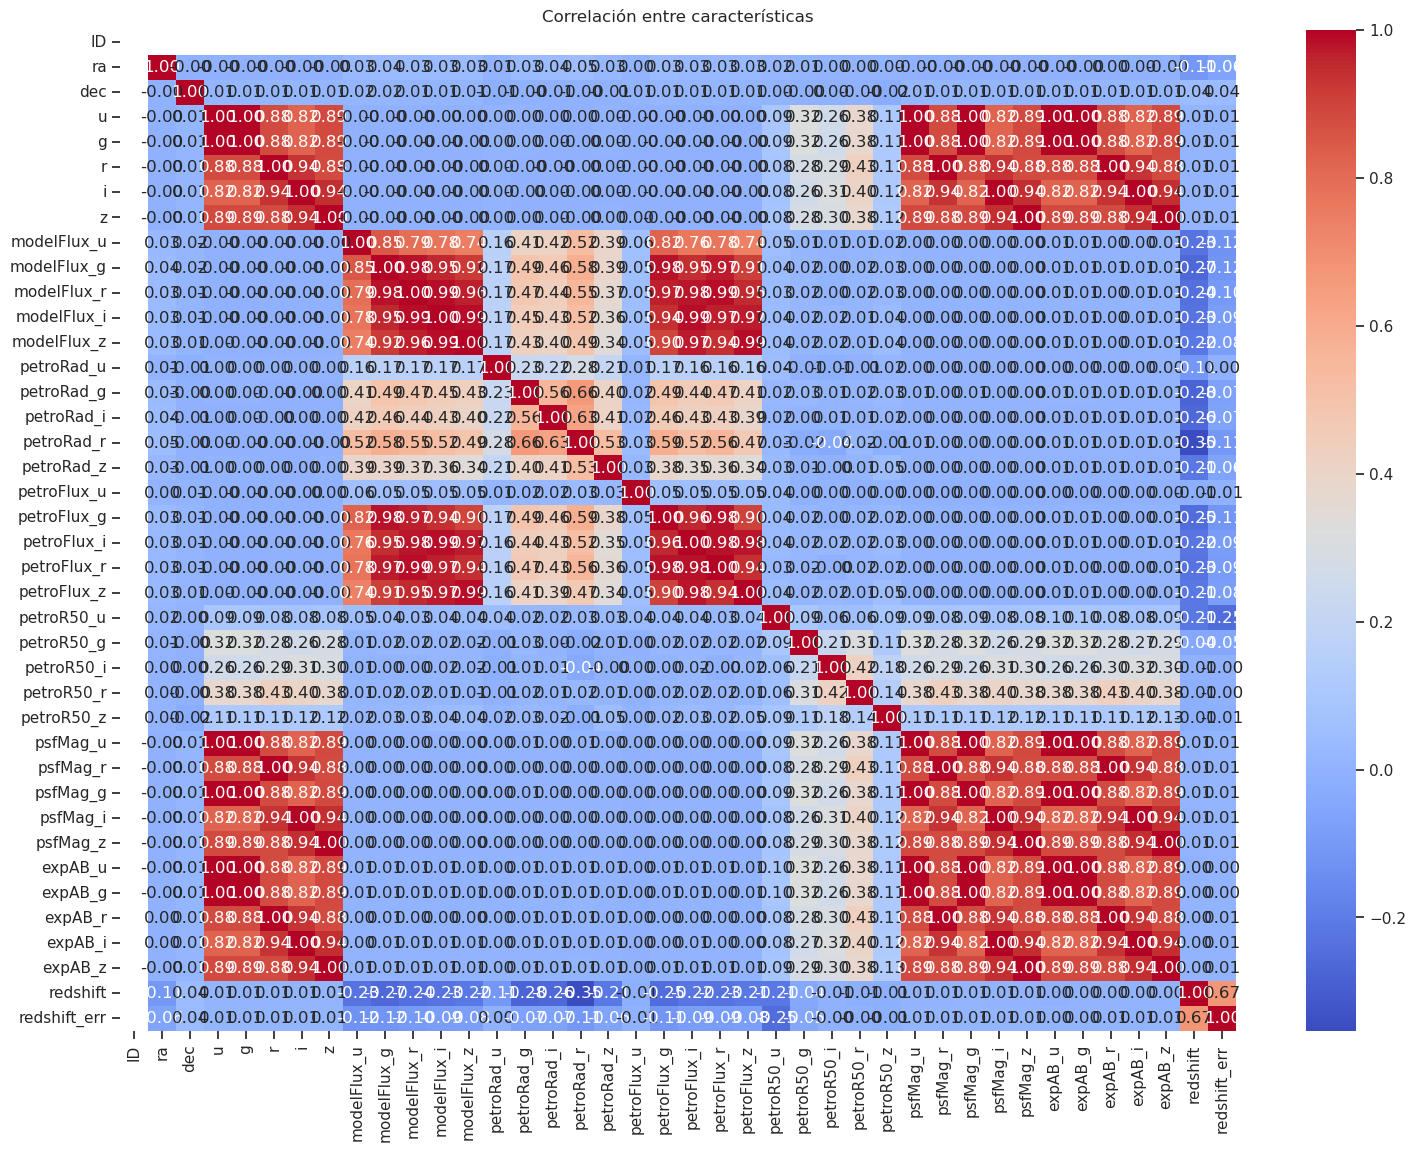

In [44]:
# Mapa de calor para correlaciones con valores
plt.figure(figsize=(18, 13))
correlation_matrix = pd.DataFrame(X, columns=train_data.columns[:-1]).corr()  # Matriz de correlación
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Correlación entre características")
plt.show()

# Entrenamiento y evaluación de modelos Random Forest, SVM, Red Neuronal

In [45]:
# --------------------------------
# Optimización del modelo Random Forest
# --------------------------------
# Definir hiperparámetros para búsqueda aleatoria
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda aleatoria de hiperparámetros
rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    random_state=42
)
rf_random_search.fit(X_train, y_train)

# Evaluación del mejor modelo
best_rf_model = rf_random_search.best_estimator_
y_val_pred_rf = best_rf_model.predict(X_val)
f1_score_rf = f1_score(y_val, y_val_pred_rf, average='macro')
print("Mejor Mean F1 Score - Random Forest:", f1_score_rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejor Mean F1 Score - Random Forest: 0.8483280174729189


In [ ]:
# --------------------------------
# Optimización del modelo de Red Neuronal
# --------------------------------
# red neuronal con capas adicionales y regularización
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Tres clases de salida
])

# Compilar el modelo con un learning rate optimizado
nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar la red neuronal
nn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluar la red neuronal
y_val_pred_nn = nn_model.predict(X_val).argmax(axis=1)
f1_score_nn = f1_score(y_val, y_val_pred_nn, average='macro')
print("Mejor Mean F1 Score - Neural Network:", f1_score_nn)

# --------------------------------
# Generar predicciones para el conjunto de test
# --------------------------------
# Predicciones con Random Forest
test_predictions_rf = best_rf_model.predict(X_test_scaled)

# Predicciones con la Red Neuronal
test_predictions_nn = nn_model.predict(X_test_scaled).argmax(axis=1)

# Guardar las predicciones en el formato solicitado
submit_rf = pd.DataFrame({'ID': test_data['ID'], 'submit': test_predictions_rf})
submit_nn = pd.DataFrame({'ID': test_data['ID'], 'submit': test_predictions_nn})

# Guardar los archivos CSV de salida
submit_rf.to_csv('submit_rf.csv', index=False)
submit_nn.to_csv('submit_nn.csv', index=False)
print("Archivos de predicciones 'submit_rf.csv' y 'submit_nn.csv' guardados.")


Epoch 1/50


E0000 00:00:1763003422.935398   24054 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763003422.943178   24054 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8323 - loss: 0.4071 - val_accuracy: 0.8698 - val_loss: 0.3048
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.8664 - loss: 0.3224 - val_accuracy: 0.8724 - val_loss: 0.2971
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8729 - loss: 0.3035 - val_accuracy: 0.8791 - val_loss: 0.2818
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8787 - loss: 0.2941 - val_accuracy: 0.8786 - val_loss: 0.2814
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8803 - loss: 0.2863 - val_accuracy: 0.8786 - val_loss: 0.2836
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8829 - loss: 0.2822 - val_accuracy: 0.8774 - val_loss: 0.2779
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8840 - loss: 0.2786 - val_accuracy: 0.8839 - val_loss: 0.2729
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8846 - loss: 0.2749 - val_accur

In [47]:
# --------------------------------
# Optimización del modelo de Red Neuronal
# --------------------------------
# red neuronal con capas adicionales y regularización
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Tres clases de salida
])

# Compilar el modelo con un learning rate optimizado
nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar la red neuronal
nn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluar la red neuronal
y_val_pred_nn = nn_model.predict(X_val).argmax(axis=1)
f1_score_nn = f1_score(y_val, y_val_pred_nn, average='macro')
print("Mejor Mean F1 Score - Neural Network:", f1_score_nn)

# --------------------------------
# Generar predicciones para el conjunto de test
# --------------------------------
# Predicciones con la Red Neuronal
test_predictions_nn = nn_model.predict(X_test_scaled).argmax(axis=1)

# Guardar las predicciones en el formato solicitado
submit_nn = pd.DataFrame({'ID': test_data['ID'], 'submit': test_predictions_nn})

# Guardar los archivos CSV de salida
submit_nn.to_csv('submit_nn.csv', index=False)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8342 - loss: 0.4028 - val_accuracy: 0.8683 - val_loss: 0.3054
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8683 - loss: 0.3172 - val_accuracy: 0.8734 - val_loss: 0.2916
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8738 - loss: 0.3012 - val_accuracy: 0.8778 - val_loss: 0.2884
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8771 - loss: 0.2957 - val_accuracy: 0.8782 - val_loss: 0.2863
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.8792 - loss: 0.2867 - val_accuracy: 0.8808 - val_loss: 0.2778
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.8821 - loss: 0.2830 - val_accuracy: 0.8794 - val_loss: 0.2776
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8837 - loss: 0.2807 - val_accuracy: 0.8818 - val_loss: 0.2721
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8841 - loss: 0.276

In [50]:
# Carga los datos
train_data = pd.read_csv('../data/galaxy_forming_burst_train.csv')
test_data = pd.read_csv('../data/galaxy_forming_burst_test.csv')

# Reemplaza valores de -99 por NaN y luego realiza imputación
train_data.replace(-99, np.nan, inplace=True)
train_data.fillna(train_data.mean(), inplace=True)

test_data.replace(-99, np.nan, inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

# Crear nuevas características basadas en magnitudes
train_data['u_g'] = train_data['u'] - train_data['g']
train_data['g_r'] = train_data['g'] - train_data['r']
train_data['r_i'] = train_data['r'] - train_data['i']
train_data['i_z'] = train_data['i'] - train_data['z']



test_data['u_g'] = test_data['u'] - test_data['g']
test_data['g_r'] = test_data['g'] - test_data['r']
test_data['r_i'] = test_data['r'] - test_data['i']
test_data['i_z'] = test_data['i'] - test_data['z']

# Preparar las características y las etiquetas
X_full = train_data.drop(columns=['target', 'ID'])
y = train_data['target']

X_test_full = test_data.drop(columns=['ID'])

# Escalar los datos
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test_full)

# Concatenar las nuevas características
X_enhanced = np.concatenate((X_full_scaled, train_data[['u_g', 'g_r', 'r_i', 'i_z']].values), axis=1)
X_test_enhanced = np.concatenate((X_test_scaled, test_data[['u_g', 'g_r', 'r_i', 'i_z']].values), axis=1)

# Dividir los datos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

# Crear la red neuronal con capas adicionales y regularización
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Tres clases de salida
])

# Compilar el modelo con un learning rate optimizado
nn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar la red neuronal
nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=1)

# Evaluar la red neuronal
y_val_pred_nn = nn_model.predict(X_val).argmax(axis=1)
f1_score_nn = f1_score(y_val, y_val_pred_nn, average='macro')
print("Mejor Mean F1 Score - Neural Network:", f1_score_nn)

# --------------------------------
# Generar predicciones para el conjunto de test
# --------------------------------
# Predicciones con la Red Neuronal
test_predictions_nn = nn_model.predict(X_test_enhanced).argmax(axis=1)

# Guardar las predicciones en el formato solicitado
submit_nn = pd.DataFrame({'ID': test_data['ID'], 'submit': test_predictions_nn})

# Guardar los archivos CSV de salida
submit_nn.to_csv('submit_nn.csv', index=False)


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8497 - loss: 0.5084 - val_accuracy: 0.8807 - val_loss: 0.2881
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8753 - loss: 0.3427 - val_accuracy: 0.8844 - val_loss: 0.2787
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8800 - loss: 0.2938 - val_accuracy: 0.8888 - val_loss: 0.2698
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8818 - loss: 0.3063 - val_accuracy: 0.8903 - val_loss: 0.2710
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8848 - loss: 0.2817 - val_accuracy: 0.8928 - val_loss: 0.2602
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8863 - loss: 0.2947 - val_accuracy: 0.8928 - val_loss: 0.2620
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8885 - loss: 0.3132 - val_accuracy: 0.8884 - val_loss: 0.2701
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8900 - loss: 0.2681 - val_accu